# Julia basic practice

## 1. Floating-point numbers

Let's check whether floating-point numbers obey certain algebraic rules.  
0. Associative rule for addition says `(x + y) + z == x + (y + z)`. Check association rule using `x = 0.1`, `y = 0.1` and `z = 1.0` in Julia. Explain what you find.

0. Do floating-point numbers obey the associative rule for multiplication: `(x * y) * z == x * (y * z)`?

0. Do floating-point numbers obey the distributive rule: `a * (x + y) == a * x + a * y`?  

0. Is `0 * x == 0` true for all floating-point number `x`?  

0. Is `x / a == x * (1 / a)` always true?

1.I find out the associative rule does not work in Julia. In the example case, we can see when x = 0.1, y = 0.1, z = 1.0, it violate the associative rule.

In [30]:
x=0.1
y=0.1
z=1.0
@show bits((x+y)+z)
@show bits((y+z)+x)
@show (x+y)+z == x+(y+z)

bits((x + y) + z) = "0011111111110011001100110011001100110011001100110011001100110011"
bits((y + z) + x) = "0011111111110011001100110011001100110011001100110011001100110100"
(x + y) + z == x + (y + z) = false


false

we can see the last bit for (x+y)+z is different from the last bit for x+(y+z). So that small difference caused the equation not equal. 

2.The associative rule works for multiplication works in Julia.


3.The distributive rule does not always work in Julia. 

For example, when x is super big and y is super small. Due to the catastrophic cancellation, x+y=x in Julia. In that case a * (x + y) will not equal to a * x + a * y

In [13]:
x = 1.0 * 2.0^30
y = 1.0 * 2.0^-10
a =10000000000
@show a * (x + y)
@show a * x + a * y
@show a * (x + y) == a * x + a * y

a * (x + y) = 1.0737418240009763e19
a * x + a * y = 1.0737418240009765e19
a * (x + y) == a * x + a * y = false


false

4.`0 * x == 0` is true for all floating-point number `x`. Because every number can be opened to the bit double precision format, and `0*x` will just apply `0*` to every bit. And the final number will be 0.

5.`x / a == x * (1 / a)` is always true. Because every number can be opened to the bit double precision format, and `x/a` will apply `/a` to every bit and adjust by shifting. And `1/a` will use 1 divided by each bit in `a`, and the number of every bit will become equal when the `*x` operation applies.

## 2. Julia functions

Consider Julia function
```julia
function g(k)
    for i = 1:10
        k = 5k - 1
    end
    k
end
```
0. Use `@code_llvm` to find the LLVM bitcode of compiled `g` with `Int64` input.   
1. Use `@code_llvm` to find the LLVM bitcode of compiled `g` with `Float64` input.  
2. Compare the bitcode from questions 1 and 2. What do you find?  
3. Read Julia documentation on `@fastmath` and repeat the questions 1-3 on the function  

```julia
function g_fastmath(k)  
    @fastmath for i = 1:10  
        k = 5k - 1
    end
    k
end
```
Explain what does macro `@fastmath` do?

In [19]:
#1.
function g(k)
    for i = 1:10
        k = 5k - 1
    end
    k
end

@code_llvm(g(2))


define i64 @julia_g_63890(i64) #0 !dbg !5 {
top:
  %1 = mul i64 %0, 9765625
  %2 = add i64 %1, -2441406
  ret i64 %2
}


In [18]:
#2.
@code_llvm(g(2.0))


define double @julia_g_63889(double) #0 !dbg !5 {
top:
  %1 = fmul double %0, 5.000000e+00
  %2 = fadd double %1, -1.000000e+00
  %3 = fmul double %2, 5.000000e+00
  %4 = fadd double %3, -1.000000e+00
  %5 = fmul double %4, 5.000000e+00
  %6 = fadd double %5, -1.000000e+00
  %7 = fmul double %6, 5.000000e+00
  %8 = fadd double %7, -1.000000e+00
  %9 = fmul double %8, 5.000000e+00
  %10 = fadd double %9, -1.000000e+00
  %11 = fmul double %10, 5.000000e+00
  %12 = fadd double %11, -1.000000e+00
  %13 = fmul double %12, 5.000000e+00
  %14 = fadd double %13, -1.000000e+00
  %15 = fmul double %14, 5.000000e+00
  %16 = fadd double %15, -1.000000e+00
  %17 = fmul double %16, 5.000000e+00
  %18 = fadd double %17, -1.000000e+00
  %19 = fmul double %18, 5.000000e+00
  %20 = fadd double %19, -1.000000e+00
  ret double %20
}


3.I find the `@code_llvm` uses different steps for the input of `Int64` and `Float64`.
When the input is integer, it takes only two steps. But it needs 20 steps when the input is the float number.

In [15]:
#4.
function g_fastmath(k)  
    @fastmath for i = 1:10  
        k = 5k - 1
    end
    k
end

@code_llvm(g_fastmath(2))
@code_llvm(g_fastmath(2.0))


define i64 @julia_g_fastmath_63399(i64) #0 !dbg !5 {
top:
  %1 = mul i64 %0, 9765625
  %2 = add i64 %1, -2441406
  ret i64 %2
}

define double @julia_g_fastmath_63401(double) #0 !dbg !5 {
top:
  %1 = fmul fast double %0, 9.765625e+06
  %2 = fadd fast double %1, -2.441406e+06
  ret double %2
}


This time the computer uses the same steps for the format of `Int64` and `Float64`.
g_fastmath provides some optimization steps that consider the floating number as the 'real' number in Julia, instead of doing the operation super carefly each time. This lacks some precision, but largely improve the speed. 

## 3. Simple ploting

Create the vector `x = (0.988, 0.989, 0.990, ..., 1.010, 1.011, 1.012)`.  
0. Plot the polynomial `y = x^7 - 7x^6 + 21x^5 - 35x^4 + 35x^3 - 21x^2 + 7x -1` at points `x`.  

1. Plot the polynomial `y = (x - 1)^7` at points `x`.  

2. Explain what you found.

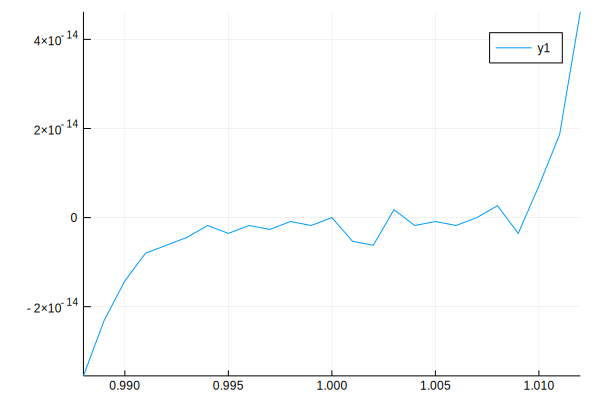

In [1]:
#1.
x = collect(0.988:0.001:1.012)

using Plots
y = x.^7 - 7.*x.^6 + 21.*x.^5 - 35.*x.^4 + 35.*x.^3 - 21.*x.^2 + 7.*x - 1
plot(x,y)

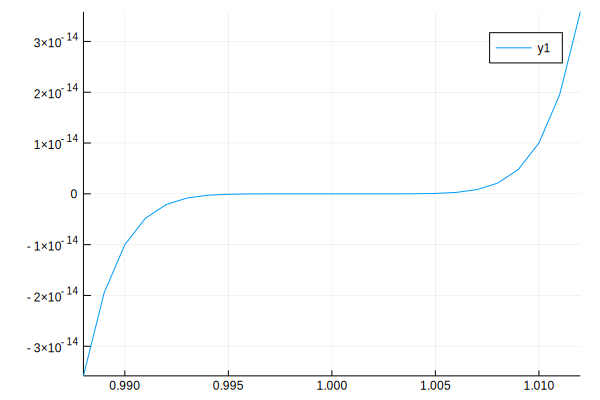

In [2]:
#2.
x=collect(0.988:0.001:1.012)

using Plots
y = (x.-1).^7
plot(x,y)

3.Although the fomula is identical in algebra, we can see the curve is much more smooth in the second case. This is due to the catastrophic cancellation. The numbers in x are all very close to 1. When we calculate `x-1`, we loos the precision of the number(only the last few bits are left after substraction). That is why the plot looks really different. 

## 4. Speed comparison

Let the $n \times n$ matrix `H` have elements `H[i, j] = 1 / (i + j - 1)`.  
0. Write a function `h(n)` that outputs $n \times n$ matrix `H`. Try at least 3 ways, e.g., looping, [comprehension](https://docs.julialang.org/en/stable/manual/arrays/#Comprehensions-1), and vectorization. Compute and print `H` for `n = 5`.   
0. Compare their efficiencies at `n = 1000`.
0. Try different rounding modes (use function `setrounding(Float64, RoundingMode)`) and report the entry `inv(H)[1, 1]` for `n = 15`.

In [2]:
#1.
function h_loop(n)
    H=zeros(n,n)
    for i in 1:n
        for j in 1:n
            H[i,j] = 1/(i+j-1)
        end
    end
    return H
end

##########

function h_comprehension(n)
    H=zeros(n,n)
    [H[i,j] = 1/(i+j-1) for i in 1:n, j in 1:n]
    return H
end

##########

function h_vertorization(n)
    A=repmat(collect(1:1:n),1,n)
    B=transpose(A)
    H=1 ./ (A+B-1)
    return H
end


h_loop(5)
h_comprehension(5)
h_vectorization(5)

5×5 Array{Float64,2}:
 1.0       0.5       0.333333  0.25      0.2     
 0.5       0.333333  0.25      0.2       0.166667
 0.333333  0.25      0.2       0.166667  0.142857
 0.25      0.2       0.166667  0.142857  0.125   
 0.2       0.166667  0.142857  0.125     0.111111

In [3]:
#2.
n=1000

using BenchmarkTools
@benchmark h_loop(n)

BenchmarkTools.Trial: 
  memory estimate:  38.22 MiB
  allocs estimate:  2012
  --------------
  minimum time:     14.127 ms (2.85% GC)
  median time:      17.955 ms (25.21% GC)
  mean time:        18.891 ms (26.75% GC)
  maximum time:     93.335 ms (85.11% GC)
  --------------
  samples:          265
  evals/sample:     1

In [4]:
@benchmark h_comprehension(n)


BenchmarkTools.Trial: 
  memory estimate:  15.26 MiB
  allocs estimate:  6
  --------------
  minimum time:     5.873 ms (0.00% GC)
  median time:      8.564 ms (24.57% GC)
  mean time:        8.678 ms (23.95% GC)
  maximum time:     71.721 ms (91.52% GC)
  --------------
  samples:          575
  evals/sample:     1

In [5]:
@benchmark h_vectorization(n)

BenchmarkTools.Trial: 
  memory estimate:  38.22 MiB
  allocs estimate:  2012
  --------------
  minimum time:     15.944 ms (2.87% GC)
  median time:      18.806 ms (25.00% GC)
  mean time:        19.544 ms (27.32% GC)
  maximum time:     99.660 ms (85.72% GC)
  --------------
  samples:          256
  evals/sample:     1

From above we can see the comprehension methods use the least time and memory, which is the most preferable method. The loop and vectorization takes much larger time and memory, and they two are similar to each other. 

In [3]:
#3.
setrounding(Float64, RoundDown)
n=15
H=h_comprehension(n)
inv(H)[1, 1]


146.44957564771175

## 5. Math

0. Show the **Sherman-Morrison formula**
$$
	(\mathbf{A} + \mathbf{u} \mathbf{u}^T)^{-1} = \mathbf{A}^{-1} - \frac{1}{1 + \mathbf{u}^T \mathbf{A}^{-1} \mathbf{u}} \mathbf{A}^{-1} \mathbf{u} \mathbf{u}^T \mathbf{A}^{-1},
$$
where $\mathbf{A} \in \mathbb{R}^{n \times n}$ is nonsingular and $\mathbf{u} \in \mathbb{R}^n$. This formula supplies the inverse of the symmetric, rank-one  perturbation of $\mathbf{A}$.

0. Show the **Woodbury formula**
$$
	(\mathbf{A} + \mathbf{U} \mathbf{V}^T)^{-1} = \mathbf{A}^{-1} - \mathbf{A}^{-1} \mathbf{U} (\mathbf{I}_m + \mathbf{V}^T \mathbf{A}^{-1} \mathbf{U})^{-1} \mathbf{V}^T \mathbf{A}^{-1},
$$
where $\mathbf{A} \in \mathbb{R}^{n \times n}$ is nonsingular, $\mathbf{U}, \mathbf{V} \in \mathbb{R}^{n \times m}$, and $\mathbf{I}_m$ is the $m \times m$ identity matrix. In many applications $m$ is much smaller than $n$. Woodbury formula generalizes Sherman-Morrison and is valuable because the smaller matrix $\mathbf{I}_m + \mathbf{V}^T \mathbf{A}^{-1} \mathbf{U}$ is cheaper to invert than the larger matrix $\mathbf{A} + \mathbf{U} \mathbf{V}^T$.

0. Show the **binomial inversion formula**
$$
	(\mathbf{A} + \mathbf{U} \mathbf{B} \mathbf{V}^T)^{-1} = \mathbf{A}^{-1} - \mathbf{A}^{-1} \mathbf{U} (\mathbf{B}^{-1} + \mathbf{V}^T \mathbf{A}^{-1} \mathbf{U})^{-1} \mathbf{V}^T \mathbf{A}^{-1},
$$
where $\mathbf{A}$ and $\mathbf{B}$ are nonsingular.

0. Show the identity
$$
	\text{det}(\mathbf{A} + \mathbf{U} \mathbf{V}^T) = \text{det}(\mathbf{A}) \text{det}(\mathbf{I}_m + \mathbf{V}^T \mathbf{A}^{-1} \mathbf{U}).
$$
This formula is useful for evaluating the density of a multivariate normal with covariance matrix $\mathbf{A} + \mathbf{U} \mathbf{V}^T$.

1.Sherman-Morrison formula proof

To prove that the backward direction $( {\displaystyle 1+v^{T}A^{-1}u\neq 0\Rightarrow A+uv^{T}} {\displaystyle 1+v^{T}A^{-1}u\neq 0\Rightarrow A+uv^{T}} $is invertible with inverse given as above) is true, we verify the properties of the inverse. A matrix ${\displaystyle Y}$ Y (in this case the right-hand side of the Sherman–Morrison formula) is the inverse of a matrix ${\displaystyle X}$ X (in this case ${\displaystyle A+uv^{T}} A+uv^{T}$) if and only if ${\displaystyle XY=YX=I} XY=YX=I$.
 
$$XY=(A+uv^T)(A^{-1}-\frac{A^{-1}uv^{T}A^{-1}}{1+v^TA^{-1}u})$$
$$=I+uv^{T}A^{-1}-\frac{u(1+v^TA^{-1}uv^{T}A^{-1}}{1+v^TA^{-1}u}$$
$$=I+uv^{T}A^{-1}-\frac{u(1+v^TA^{-1}u)v^TA^{-1}}{1+v^TA^{-1}u}$$
$$=I+uv^{T}A^{-1}-uv^{T}A^{-1}$$
$$=I$$

In the same way we can verify that 
$$YX=\left(A^{-1}-{A^{-1}uv^{T}A^{-1} \over 1+v^{T}A^{-1}u}\right)(A+uv^{T})=I$$


2.Woodbury formula proof

$$(A+UV^T)(A^{-1}-A^{-1}U(I+V^{T}A^{-1}U)^{-1}V^TA^{-1})$$
$$=I+UV^TA^{-1}-U(I+V^TA^{-1}U)^{-1}V^TA^{-1}-UV^TA^{-1}U(I+V^TA^{-1}U)^{-1}V^TA^{-1}$$
$$=I+U(I-(I+V^TA^{-1}U)^{-1}-V^TA^{-1}U(I+V^TA^{-1}U)^{-1})V^TA^{-1}$$
$$=I+U(I+V^TA^{-1}U-I-V^TA^{-1}U)(I+V^TA^{-1}U)^{-1}V^TA^{-1}$$
$$=I$$


3.Binomial inversion formula proof

$$(A+UBV)[A^{-1}-A^{-1}U(B^{-1}+VA^{-1}U)^{-1}VA^{-1}]$$
$$=\{I+UBVA^{-1}\}-\{U(B^{-1}+VA^{-1}U)^{-1}VA^{-1}+UBVA^{-1}U(B^{-1}+VA^{-1}U)VA^{-1}\}$$
$$=I+UCVA^{-1}-(U+UCVA^{-1}U)(C^{-1}+VA^{-1}U)^{-1}VA^{-1}$$
$$=I+UCVA^{-1}-UC(C^{-1}=VA^{-1}U)(C^{-1}+VA^{-1}U)^{-1}VA^{-1}$$
$$=I+UCVA^{-1}-UCVA^{-1}$$
$$=I$$


4.When it is the special case $A=I$, follows the equanlity
$$det(I+UV^T=(1+V^TU))$$
Then the general case can be found as:
$$det(A+UV^T)=det(A)det(I+(A^{-1}U)V^T)$$
$$=det(A)(1+V^T(A^{-1}U))$$
When we further genralize it, it becomes
$$det(A+UV^T)=det(I_{m}+V^TA^{-1}U)det(A)$$